# Continuous Control

---

In this notebook, D3PG agent will be implemented and tested on the Reacher Unity Environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='C:\\Users\\anindex\\Desktop\\Reacher_Windows_x86_64_20\\Reacher_Windows_x86_64\\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with ength: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with ength: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training DDPG agent

The implementation for DDPG agent is imported from this repository subfolder `agents/` as a library. 

In [5]:
import sys
import os
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#uncomment the following line if import failed
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from agents.agents import DDPGAgent

agent = DDPGAgent(state_size, action_size, random_seed=0, num_agents=num_agents)

In [ ]:
# loading checkpoint if the file exists

if os.path.isfile('actor.pth') and os.path.isfile('actor.pth'):
    agent.actor_local.load_state_dict(torch.load('actor.pth'))
    agent.actor_target.load_state_dict(torch.load('actor.pth'))
    agent.critic_local.load_state_dict(torch.load('critic.pth'))
    agent.critic_target.load_state_dict(torch.load('critic.pth'))
    print("Loaded previous trained DDPG agent!")

In [6]:
def train_ddpg(n_episodes=2000, max_t=1000, print_every=100, save_every=500):
    """Distributional DDPG (D3PG)
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                                # list containing scores from each episode
    scores_window = deque(maxlen=print_every)  # last print_every scores

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        states = env_info.vector_observations
        current_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations  
            rewards = env_info.rewards                
            dones = env_info.local_done
            current_scores += env_info.rewards  
            
            for i in range(num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
                
            states = next_states
            if np.any(dones):
                break 
        avg_score = np.mean(current_scores)
        scores_window.append(avg_score)       # save most recent score
        scores.append(avg_score)              # save most recent score

        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, avg_score))
        if mean_score >= 33.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, saving models!'.format(i_episode, mean_score))
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
    return scores

scores = train_ddpg(n_episodes=200, print_every=10)

KeyboardInterrupt: 

In [7]:
# run this cell for saving scores and Q network state_dict

import pickle

with open('DDPG_control_scores', 'wb') as fp:
    pickle.dump(scores, fp)
    
torch.save(agent.actor_local.state_dict(), 'actor.pth')
torch.save(agent.critic_local.state_dict(), 'critic.pth')

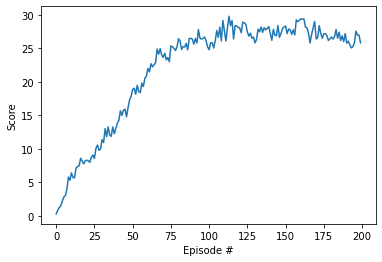

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Evaluate the agent

We will then observe the trained behavior of the DDPG agent ands finally record the total average score of 20 agents. This cell will load the saved model and test the model on the env.

In [9]:
agent = DDPGAgent(state_size, action_size, random_seed=0, num_agents=num_agents)
agent.actor_local.load_state_dict(torch.load('actor_v1.pth'))
agent.critic_local.load_state_dict(torch.load('critic_v1.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)

    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 28.522499362472445


In [10]:
env.close()